<a href="https://colab.research.google.com/github/lorenzosintini/4YP/blob/master/CVAE_MNIST_Numbers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import Libraries

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import sys
from IPython.display import clear_output
import os
tf.autograph.set_verbosity(0)

TensorFlow 2.x selected.


#### Import Data and plot it

11493376/11490434 [==============================] - 0s 0us/step


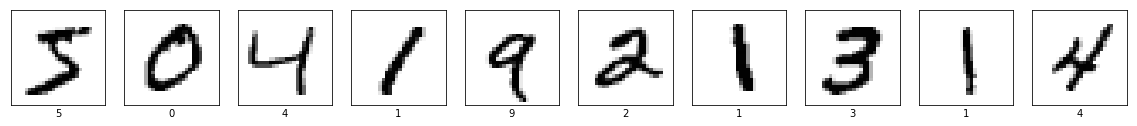

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

class_names = ['Zero','One', 'Two', 'Three', 'Four', 'Five','Six', 'Seven', 'Eight', 'Nine']
N_image_channels = 1
N_class = len(class_names)
image_shape = x_train.shape[1:3]
input_range = np.amax(x_train)

def plot_images(x_train, y_train, figures_to_plot, pick_random=False, include_labels=True):
    n_rows = np.ceil((figures_to_plot[1])/10)
    plot = plt.figure(figsize=[20,2*n_rows])
    for i in range(figures_to_plot[0],figures_to_plot[1]):
        if pick_random: 
            pic_n = random.randint(0,len(x_train))
        else: pic_n = i
        plt.subplot(n_rows,10,i+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(x_train[pic_n], cmap=plt.cm.binary)
        if include_labels:
            plt.xlabel(y_train[pic_n])
    plt.show()

plot_images(x_train, y_train, [0,10])

#### Select data, pre-process it and create dataset

In [0]:
def preprocess(x_train, x_test, y_train, y_test):
  train_images = x_train/input_range
  test_images = x_test/input_range

  def set_pixels_binary(images):
    images[images >= 0.5] = 1.0
    images[images < 0.5] = 0.0
    return images

  train_images = set_pixels_binary(train_images)
  test_images = set_pixels_binary(test_images)
  train_labels = y_train
  test_labels = y_test
  return train_images, test_images, train_labels, test_labels

def setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2]):
  def pick_class(x, y, class_n):
    pics = (y == class_n[0])
    for i in range(len(class_n)-1):
      pics = pics + (y == class_n[i+1])
    new_x = x[pics]
    new_y = y[pics]
    return new_x, new_y

  x_train, y_train = pick_class(x_train, y_train, chosen_classes)
  x_test, y_test = pick_class(x_test, y_test, chosen_classes)

  
  data_input = -1
  x_train = x_train[0:data_input]
  y_train = y_train[0:data_input]

  N_train = len(y_train)
  N_test = len(y_test)

  train_images, test_images, train_labels, test_labels = preprocess(x_train, x_test, y_train, y_test)
  
  train_images = train_images.reshape(N_train, image_shape[0], image_shape[1], N_image_channels).astype('float32')
  test_images = test_images.reshape(N_test, image_shape[0], image_shape[1], N_image_channels).astype('float32')

  batch_size = 100
  train_dataset = tf.data.Dataset.from_tensor_slices((train_images)).shuffle(N_train).batch(batch_size)
  test_dataset = tf.data.Dataset.from_tensor_slices((test_images)).shuffle(N_test).batch(batch_size)
  return x_train, y_train, x_test, y_test, train_dataset, test_dataset

#### Create Variational Autoencoder (VAE) Model

In [0]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.encoder_nn = tf.keras.models.Sequential([ 
                          tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
                          tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(z_size*2)
                          ])

        self.decoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Dense(units=24*24*64, activation='relu', input_shape=(z_size,)),
                          tf.keras.layers.Reshape(target_shape=(24, 24, 64)),
                          tf.keras.layers.Conv2DTranspose(32, (3,3), activation='relu'),
                          tf.keras.layers.Conv2DTranspose(1, (3,3)),
                          ])

    def encode(self, x):
        encoder_nn_output = self.encoder_nn(x)
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sampled = epsilon * tf.exp(z_logvar * 0.5) + z_mean
        return z_sampled
      

    def decode(self, z):
        pixel_output = self.decoder_nn(z)
        pixel_prob = tf.math.sigmoid(pixel_output)
        return pixel_prob

#### Define the loss function 

In [0]:
def calculate_ELBO(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    
    pixel_prob = model.decode(z)
    
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*x + tf.math.log(1-pixel_prob + 1e-10)*(1-x)
    logpx_z_images = tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    logpx_z = tf.reduce_mean (logpx_z_images)
    
    KL_parameters = -0.5 * (1 + z_logvar - (z_mean ** 2.0) - tf.exp(z_logvar))
    KL_vectors = tf.reduce_sum(KL_parameters, axis=1)
    KL = tf.reduce_mean(KL_vectors)
    
    ELBO = (logpx_z - KL)
    
    return -ELBO #Negative because we want to maximise it

#### Define the optimizer

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

#### Define loss metrics

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

#### Define train and test steps

In [0]:
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_ELBO(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x, optimizer):
    loss = calculate_ELBO(model, x)
    test_loss(loss)

#### Generate random image from latent vector

In [0]:
def generate_images(model, z_random, figures_to_plot):
    generated_prob = model.decode(z_random)
    generated_prob = np.squeeze(generated_prob, axis=3)
    plot_images(generated_prob, _, figures_to_plot, include_labels=False)

In [0]:
def train_test_dataset(model, train_dataset, test_dataset, epochs, generate=True):
  plots_per_epoch = 10
  z_random = tf.random.normal(shape=[plots_per_epoch, z_size])
  
  test_ELBO = []
  train_ELBO = []
  epoch_number = []  
  for epoch in range(epochs):
    for i, train_x in enumerate(train_dataset): 
      sys.stdout.write('\r'+'Epoch {}'.format(epoch))
      sys.stdout.flush()
      train_step(model, train_x, optimizer)
  
    for i, test_x in enumerate(test_dataset):
      test_step(model, test_x, optimizer)
    
    test_ELBO.append(-test_loss.result())
    train_ELBO.append(-train_loss.result())
    epoch_number.append(epoch)
    
    clear_output()
    if generate:
      generate_images(model, z_random, [0,plots_per_epoch])
    plt.plot(epoch_number, test_ELBO, train_ELBO)
    plt.legend(['test','train'])
    plt.title('model')
    plt.show()
  train_loss.reset_states()
  test_loss.reset_states()

#### Train the data

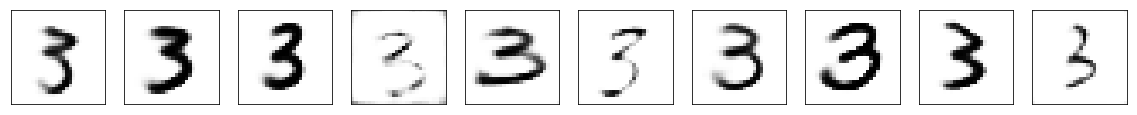

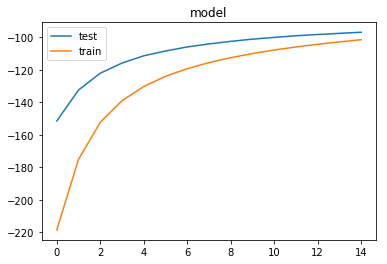

In [11]:
x_train_0, y_train_0, x_test_0, y_test_0, train_dataset_0, test_dataset_0 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0])
x_train_1, y_train_1, x_test_1, y_test_1, train_dataset_1, test_dataset_1 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[1])
x_train_2, y_train_2, x_test_2, y_test_2, train_dataset_2, test_dataset_2 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[2])
x_train_3, y_train_3, x_test_3, y_test_3, train_dataset_3, test_dataset_3 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[3])
x_train_4, y_train_4, x_test_4, y_test_4, train_dataset_4, test_dataset_4 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[4])
x_train_5, y_train_5, x_test_5, y_test_5, train_dataset_5, test_dataset_5 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[5])
x_train_6, y_train_6, x_test_6, y_test_6, train_dataset_6, test_dataset_6 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[6])
x_train_7, y_train_7, x_test_7, y_test_7, train_dataset_7, test_dataset_7 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[7])
x_train_8, y_train_8, x_test_8, y_test_8, train_dataset_8, test_dataset_8 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[8])
x_train_9, y_train_9, x_test_9, y_test_9, train_dataset_9, test_dataset_9 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[9])

z_size = 10
model_0 = CVAE(z_size)
model_1 = CVAE(z_size)
model_2 = CVAE(z_size)
model_3 = CVAE(z_size)
model_4 = CVAE(z_size)
model_5 = CVAE(z_size)
model_6 = CVAE(z_size)
model_7 = CVAE(z_size)
model_8 = CVAE(z_size)
model_9 = CVAE(z_size)

model_dict = {'0' : model_0,
              '1' : model_1,
		          '2' : model_2,
              '3' : model_3,
              '4' : model_4,
              '5' : model_5,
              '6' : model_6,
              '7' : model_7,
              '8' : model_8,
              '9' : model_9,}

train_test_dataset(model_0, train_dataset_0, test_dataset_0, 15, generate=True)
train_test_dataset(model_1, train_dataset_1, test_dataset_1, 15, generate=True)
train_test_dataset(model_2, train_dataset_2, test_dataset_2, 15, generate=True)
train_test_dataset(model_3, train_dataset_3, test_dataset_3, 15, generate=True)
# train_test_dataset(model_4, train_dataset_4, test_dataset_4, 15, generate=True)
# train_test_dataset(model_5, train_dataset_5, test_dataset_5, 15, generate=True)
# train_test_dataset(model_6, train_dataset_6, test_dataset_6, 15, generate=True)
# train_test_dataset(model_7, train_dataset_7, test_dataset_7, 15, generate=True)
# train_test_dataset(model_8, train_dataset_8, test_dataset_8, 15, generate=True)
# train_test_dataset(model_9, train_dataset_9, test_dataset_9, 15, generate=True)

#### Reconstruct images

Original Pictures:


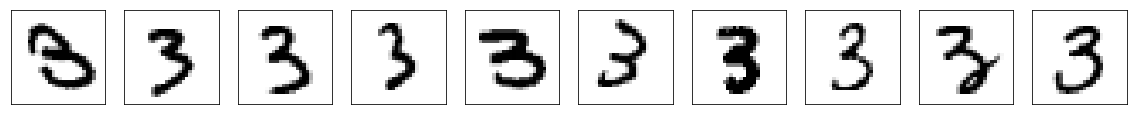

Reconstructed Pictures, with ELBO loss:


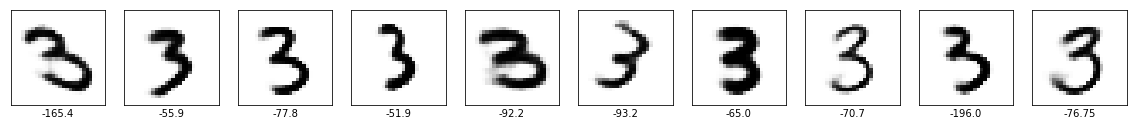

In [31]:
def reconstruct_images(model, images):
    images_n = len(images)
    x = images/input_range
    x[x >= 0.5] = 1.0
    x[x < 0.5] = 0.0
    x = x.reshape(images_n, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_output = model.decode(z)
    pixel_prob = tf.math.sigmoid(pixel_output)
    pixel_prob = np.squeeze(pixel_prob, axis=3)

    loss = np.empty([images_n])
    for i in range(images_n):
        loss[i] = calculate_ELBO(model,x[i:i+1])
    loss = loss.astype('float16')
    
    print('Original Pictures:')
    plot_images(images, _, figures_to_plot=[0,images_n], include_labels=False)
    print('Reconstructed Pictures, with ELBO loss:')
    plot_images(pixel_prob, -loss, figures_to_plot=[0,images_n], include_labels=True)

reconstruct_images(model_3, x_test_3[0:10])


#### Visualize the latent space

In [0]:
def visualize_latent_space(model, range1, range2, data_x, data_y, a, b):
  plot = plt.figure(figsize=[7,7])
  outliers=0
  for i in range(range1, range2):
    pic_visualize = data_x[i]
    pic_visualize = pic_visualize.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    
    z_mean, z_logvar = model.encode(pic_visualize)
    z = model.reparameterize(z_mean, z_logvar)
    
    if any(z_logvar[:,i]>5 for i in range(10)):
      outliers +=1
      continue
      
    if data_y[i] == 0:
      color = 'blue'
    if data_y[i] == 1:
      color = 'orange'
    if data_y[i] == 2:
      color = 'green'
    if data_y[i] == 3:
      color = 'red'
    if data_y[i] == 4:
      color = 'purple'  
    if data_y[i] == 5:
      color = 'brown'
    if data_y[i] == 6:
      color = 'pink'
    if data_y[i] == 7:
      color = 'gray'
    if data_y[i] == 8:
      color = 'black'
    if data_y[i] == 9:
      color = 'yellow'
    plt.scatter(z[:,a],z[:,b], color=color, s=10)
    #plt.xlim([-1000,1000])
    #plt.ylim([-1000,1000])
    #plt.annotate('{}'.format(i),(z[:,a],z[:,b]))
  print('{} Outliers detected'.format(outliers))


#visualize_latent_space(model_0, 0,800, x_test_0, y_test_0, 1,4)

#labels = []; 
#for i in range(N_train): labels.append(i)
#plot_images(x_train, labels, [250,300])

#### Check reconstruction performance for untrained classes


Model trained with class 1


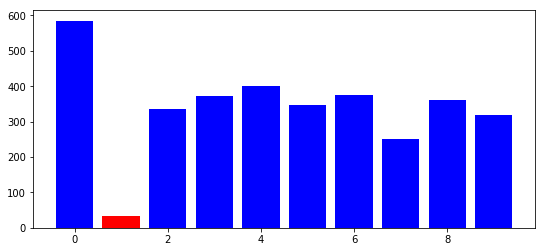

Model trained with class 2


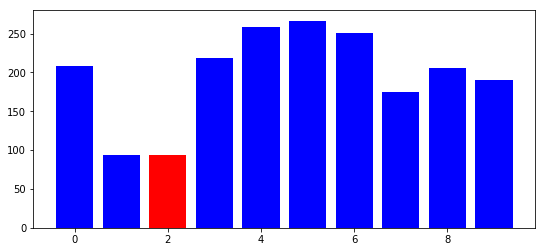

Model trained with class 3


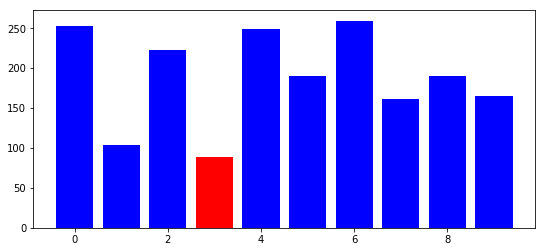

In [77]:
for i in range(1,4):
  model = model_dict[str(i)]
  print('Model trained with class {}'.format(i))
  plt.figure(figsize=[9,4])
  for j in range(N_class):
    test_images = x_test[(y_test==j)]
    test_images = test_images/input_range
    test_images[test_images >= 0.5] = 1.0
    test_images[test_images < 0.5] = 0.0
    test_images = test_images.reshape(len(test_images), image_shape[0], image_shape[1], N_image_channels).astype('float32')
    loss = -calculate_ELBO(model,test_images)
    if j==i:
      color='red'
    else:
      color='blue'
    plt.bar(j,-loss.numpy(),color=color)
    #print('ELBO loss for class {}: {}'.format(i,loss))
  plt.show()
  

# reconstruct_images(x_test[(y_test==8)][0:10], test_images[(y_test==8)][0:10])

#visualize_latent_space(0,1000, x_train, y_train, 0,1)
#classes_to_pick = [1]
#x_reconstruct_test, y_reconstruct_test = pick_class(x_test, y_test, classes_to_pick)
#visualize_latent_space(0,100, x_reconstruct_test, y_reconstruct_test, 0,1)


#### Classify test images

In [107]:
_, _, x_test_classes, y_test_classes, _, _ = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[1,2,3])
predicted_class = np.zeros([1,len(x_test_classes)])
for i in range(len(x_test_classes)):
  test_image = x_test_classes[i]/input_range
  test_image[test_image >= 0.5] = 1.0
  test_image[test_image < 0.5] = 0.0
  test_image = test_image.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
  
  loss_per_model = []
  for j in range(0,4):
    model = model_dict[str(j)]
    loss = -calculate_ELBO(model,test_image)
    #print('ELBO loss for class {}: {}'.format(i,loss))
    loss_per_model.append(loss)
  predicted_class[0,i] = loss_per_model.index(max(loss_per_model))
print(predicted_class)

[[2. 1. 1. ... 1. 2. 3.]]


#### Check accuracy and plot misslabeled images

Correctly labelled pictures:3165/3177 -> Accuracy: 99.6222851746931%
Incorrectly labelled pictures:12/3177 -> Error: 0.37771482530689626%


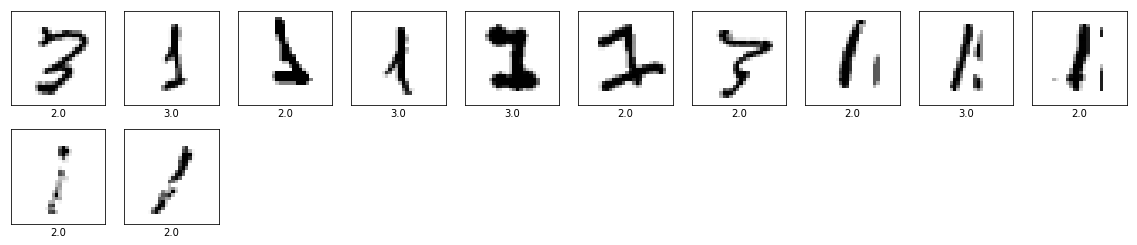

In [163]:
correct_guesses = 0
wrong_guesses = []
for i,x in enumerate(zip(predicted_class[0,:], y_test_classes)):
  if (x[0]==x[1]):
    correct_guesses = correct_guesses + 1
  else:
    wrong_guesses.append(i)

total_guesses = len(x_test_classes)
accuracy = (correct_guesses/total_guesses)
print('Correctly labelled pictures:{}/{} -> Accuracy: {}%'.format(correct_guesses,total_guesses,accuracy*100))
print('Incorrectly labelled pictures:{}/{} -> Error: {}%'.format(total_guesses-correct_guesses,total_guesses,(1-accuracy)*100))


pics_to_plot = list(x_test_classes[i] for i in wrong_guesses)
labels = list(predicted_class[0,i] for i in wrong_guesses)
plot_images(pics_to_plot, labels, [0,len(labels)])